# Swap with Counterparty Risk (CVA)

The goal of the project is to compute the market value of a swap where the counterparty might default. The input parameters are:

* the par rate of a set of Overnight Index Swaps (i.e. their market quotation);
* a set of forward libor rates and their fixing dates;
* a set of survival probabilities for the risky counterparty;
* the static data of the swap (nominal, maturity, underlying libor tenor, etc..). The fixed rate of the swap is such that if there was no counterparty risk, the product would be traded at par. You are requested to compute it;
* the recovery rate for this swap;
* the volatility of the swap rate, which is assumed to be constant through time (the swap rate assumed to evolve according to GBM with fixed diffusion and zero drift).

## Notes and Hints

Numerical results must be presented to the examining committee during a presentation in which the candidates will also explain the theoretical framework for CVA estimation

Try to reuse as much as possible the code developed in $\texttt{finmarkets.py}$.

When this is not possible write your own classes.

**Pay attention to annuity calculation.**

Credit Valuation Adjustment risk is the potential source of loss due to changes in counterparty credit spreads and other market risk factors: bank that undertake derivative or securities financing transactions are subject to the risk of incurring mark-to -market losses because of the deterioration in the creditworthiness of their counterparties. CVA is complementary to the risk of a counterparty defaulting, which is known as counterparty credit risk. While Credit VaR measures the risk of losses faced due to the possible default of some counterparty, CVA measures the pricing component of this risk.

To compute it, we first started with the Bootstrapping technique: we defined the Overnight Index Swap from market quotes, then our objective function was the discount rate obtained through the minimization process. After, we defined the credit curve from surival probabilities. Given the forward rate curve equal to the euribor 6 months and defined our Interest Rate Swap, we was able to proceed with the computation of the CVA: we simulated the development the portfolio (its NPV) at each time point for each Montecarlo scenario then we made the average of the CVAs of all the scenarios to get the estimate of the CVA.

In [ ]:
import sys
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/finance_course/Projects')

Mounted at /content/drive


In [ ]:
from datetime import date
import pandas as pd

today = date.today() 

# par swap data
nominal = 100e6 
libor_tenor = 6
fixed_leg_frequency = 12
maturity = 60

# CVA data
recovery = 0.40 
sigma = 0.30

ois_quotes = pd.read_excel("https://github.com/matteosan1/finance_course/raw/develop/Projects/ois_quotes.xlsx")
surv_prob = pd.read_csv("https://raw.githubusercontent.com/matteosan1/finance_course/develop/Projects/survival_probabilities_proj7.csv")
euribor6m = pd.read_excel("https://github.com/matteosan1/finance_course/raw/develop/Projects/euribor_curve.xlsx", sheet_name="EURIBOR6M")

In [ ]:
print (ois_quotes.head())

   months   quotes
0       1  0.70575
1       2  1.03170
2       3  1.23200
3       4  1.42975
4       5  1.59400


In [ ]:
from finmarkets import OvernightIndexSwap

pillar_dates = [today]
swaps = []
for q in range(len(ois_quotes)):
  swap = OvernightIndexSwap(nominal, today, 
                            ois_quotes.loc[q, 'quotes']*0.01, 
                            ois_quotes.loc[q, 'months'])
  swaps.append(swap)
  pillar_dates.append(swap.payment_dates[-1])

In [ ]:
import numpy as np
from finmarkets import DiscountCurve

def objective_function(x):
    x = np.insert(x, 0, 1)
    curve = DiscountCurve(pillar_dates, x)
    s = 0
    for swap in swaps:
        s += swap.npv(curve)**2
    return s

In [ ]:
x0 = [1 for _ in range(len(swaps))]
bounds = [(0.01, 10) for _ in range(len(x0))]

In [ ]:
from scipy.optimize import minimize

r = minimize(objective_function, x0, bounds=bounds)
print (r)

      fun: 6.027291211461803
 hess_inv: <30x30 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 113033.02697077,  177041.47793492,  201395.18590628,
        184992.2207603 ,  136709.41413187,   81074.92703957,
         35855.37038222,   15722.19081649,   22074.28040297,
         48559.04954838,   81833.74960126, -113964.05877223,
        -92862.24897313,  191061.11788342,   89747.28549932,
         29430.23293147,  -17443.81185765,  -21274.69373686,
        -27127.08655397,  -23315.48377396,  -18696.81902476,
         -9480.93762375,  -29433.29616068, -340786.23434701,
         75066.51058204, -356485.51115995, -254523.90619517,
         17541.59110595, -183678.3644801 ,   86253.79349   ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 465
      nit: 11
     njev: 15
   status: 0
  success: True
        x: array([0.99941222, 0.99825489, 0.99686143, 0.99525677, 0.99335846,
       0.99136706, 0.9892002 , 0.98696958, 0.98469213, 0.98233439,
       0.9800

In [ ]:
dfs = np.insert(r.x, 0, 1)
dc = DiscountCurve(pillar_dates, dfs)

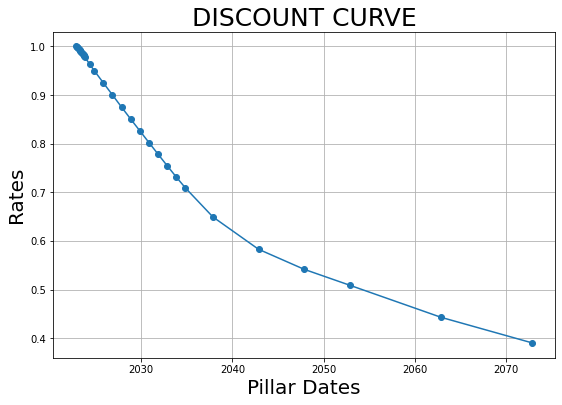

In [ ]:
from matplotlib import pyplot as plt
    
plt.plot(pillar_dates, dfs, marker='o')
plt.xlabel('Pillar Dates', fontsize=20)
plt.ylabel('Rates', fontsize=20)
plt.title(r'DISCOUNT CURVE', fontsize=25)
plt.grid(True)
plt.show()

In [ ]:
from finmarkets import CreditCurve
from dateutil.relativedelta import relativedelta

dates = [today + relativedelta(years=i) for i in surv_prob['years']]
cc = CreditCurve(dates, surv_prob['ndp'])

In [ ]:
print (surv_prob.head())

   years     ndp
0      0  1.0000
1      1  0.9722
2      2  0.9429
3      3  0.9134
4      5  0.8556


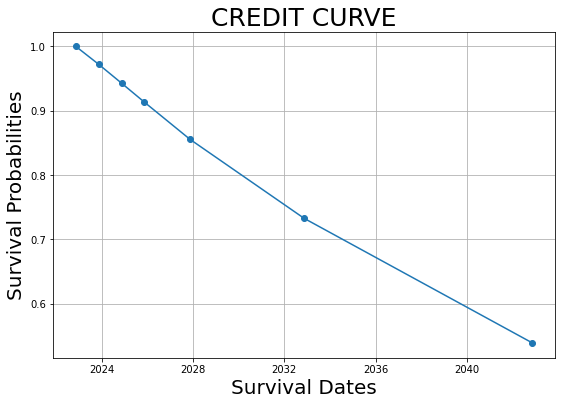

In [ ]:
plt.plot(dates, surv_prob['ndp'], marker='o')
plt.xlabel('Survival Dates', fontsize=20)
plt.ylabel('Survival Probabilities', fontsize=20)
plt.title(r'CREDIT CURVE', fontsize=25)
plt.grid(True)
plt.show()

In [ ]:
from finmarkets import ForwardRateCurve

dates = [today + relativedelta(months=i) for i in euribor6m['months']]
fr = ForwardRateCurve(dates, euribor6m['rates']*0.01)

In [ ]:
from finmarkets import generate_dates

class InterestRateSwap:
  def __init__(self, notional, start_date, fixed_rate,
               tenor_months, maturity_years):
    self.notional = notional
    self.fixed_rate = fixed_rate
    self.fixed_leg_dates = generate_dates(start_date, 12 * maturity_years)
    self.floating_leg_dates = generate_dates(start_date, 12 * maturity_years,
                                             tenor_months)

  def annuity(self, discount_curve, pricing_date=None):
    if pricing_date is None:
      pricing_date = self.fixed_leg_dates[0]
    a = 0
    for i in range(1, len(self.fixed_leg_dates)):
      if self.fixed_leg_dates[i] >= pricing_date:
        a += discount_curve.df(self.fixed_leg_dates[i])
    return a

  def swap_rate(self, discount_curve, libor_curve):
    s = 0
    for j in range(1, len(self.floating_leg_dates)):
      F = libor_curve.forward_rate(self.floating_leg_dates[j-1],
                                   self.floating_leg_dates[j])
      tau = (self.floating_leg_dates[j] - self.floating_leg_dates[j-1]).days / 360
      P = discount_curve.df(self.floating_leg_dates[j])
      s += F * tau * P
    return s / self.annuity(discount_curve)

  def npv(self, discount_curve, libor_curve):
    S = self.swap_rate(discount_curve, libor_curve)
    A = self.annuity(discount_curve)
    return self.notional * (S - self.fixed_rate) * A


In [ ]:
irs_dummy = InterestRateSwap(nominal, today, 10, libor_tenor, 5)
fixed_rate = irs_dummy.swap_rate(dc, fr)
print (fixed_rate)

0.03285538854742377


In [ ]:
irs = InterestRateSwap(nominal, today, fixed_rate, libor_tenor, 5)
irs.npv(dc, fr)

0.0

In [ ]:
import math, numpy

numpy.random.seed(1)
T = 5

sigma_daily = sigma/math.sqrt(365)
n_scenarios = 100

cvas = []
npvs = []
aS = []
apath = []
for i_scenario in range(n_scenarios):
  cva = 0
  S = irs.swap_rate(dc, fr)
  temp = []
  for d in range(0, 365*T): 
      A = irs.annuity(dc, today+relativedelta(days=d))
      S = S * math.exp(-0.5 * sigma_daily * sigma_daily + sigma_daily * numpy.random.normal())
      swap_npv = irs.notional * (S - irs.fixed_rate) * A
      temp.append(max(0, swap_npv))
      cva += (max(0, swap_npv)) * (cc.ndp(today+relativedelta(days=d)) - cc.ndp(today+relativedelta(days=d+1)))
  apath.append(temp)
  cvas.append(cva*(1-recovery))
  npvs.append((max(0, swap_npv)))
    
    
print ("CVA: {: 2f}".format(numpy.mean(cvas)))

CVA:  176751.386768


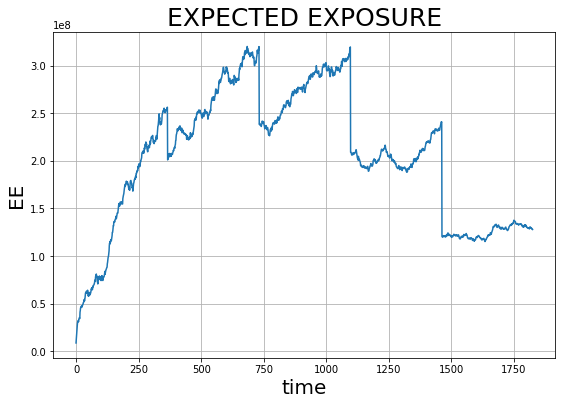

In [ ]:
import numpy as np

plt.rcParams['figure.figsize'] = (9,6)
plt.plot(range(365*T), np.sum(np.array(apath), axis=0))
plt.xlabel('time', fontsize=20)
plt.ylabel('EE', fontsize=20)
plt.title(r'EXPECTED EXPOSURE', fontsize=25)
plt.grid(True)
plt.show()